# A/B Testing of E Commerce Data

Importing Packages required.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

###### DATA PREPROCESSING
Getting the data from github repo

In [2]:
data_path="https://raw.githubusercontent.com/ChandiniGanesan/A-B-Testing-for-an-e-commerce-company/master/ab_data.csv"
df_ecommerce=pd.read_csv(data_path,dtype={"user_id": int, "timestamp": object,"group":object,"landing_page":object,"converted":object},header=0)


Checking if data download and save to the dataframe was successful using head()

In [3]:
df_ecommerce.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


Identifying number of rows and unique users in the dataset

In [16]:
print("Dimension of the table:",df_ecommerce.shape)
print("Number of Rows:",len(df_ecommerce))

Dimension of the table: (294478, 5)
Number of Rows: 294478


In [5]:
print("Number of unique users:"),len(df_ecommerce["user_id"].unique())

Number of unique users:


(None, 290584)

Calculating proportions of users converted

In [17]:
df_ecommerce["converted"]=df_ecommerce["converted"].astype('int64')
df_ecommerce["converted"].dtype
df_ecommerce["converted"].value_counts(normalize=True)*100



0    88.034081
1    11.965919
Name: converted, dtype: float64

Occurance of new_page along with treatment in the dataset

In [7]:
df_ecommerce.groupby(["group","landing_page"]).size().reset_index(name="Occurance")

,group,landing_page,Occurance
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


Checking for missing values

In [19]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int32
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int32(1), int64(1), object(3)
memory usage: 10.1+ MB


In A/B Testing we know that "control" refers to old version and "treatment" refers to new version. However we see that there are a 1965 records with old_page for treatment category and 1928 for new_page. These 3893 records are not useful as we cannot be sure of the reliability of user response. Hence removing these rows.

In [34]:
df_ecommerce.drop(df_ecommerce[(df_ecommerce.group=="control") & (df_ecommerce.landing_page=="new_page")].index,inplace=True)
df_ecommerce.drop(df_ecommerce[(df_ecommerce.group=="treatment") & (df_ecommerce.landing_page=="old_page")].index,inplace=True)

Checking if drop was successful

In [35]:
df_ecommerce.groupby(["group","landing_page"]).size().reset_index(name="Occurance")

,group,landing_page,Occurance
0,control,old_page,145274
1,treatment,new_page,145311


Obtaining number of unique users of the new dataset

In [42]:
len(df_ecommerce["user_id"].unique())

290584

Obtaining non unique user 

In [58]:
df_ecommerce[df_ecommerce["user_id"].duplicated()].user_id

2893    773192
Name: user_id, dtype: int32

In [56]:
df_ecommerce[(df_ecommerce.user_id==773192)]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


Removing the user duplicate as both records show that the user belongs to treatment and has not converted.

In [69]:
df_ecommerce.drop_duplicates(subset='user_id' ,keep="last",inplace=True)
print(df_ecommerce.shape)

(290584, 5)


Checking if duplicates were removed

In [70]:
df_ecommerce[(df_ecommerce.user_id==773192)]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


### Probabilities

To perform A/B testing, it is required to be aware of the probability of converted regardless of the page they receive.

In [76]:
print("Probability that a user is converted is :",df_ecommerce["converted"].value_counts(normalize=True)[1])

Probability that a user is converted is : 0.11959708724499628


In [113]:
p_control=len(df_ecommerce[(df_ecommerce.group=="control") & (df_ecommerce.converted==1)])/len(df_ecommerce[(df_ecommerce.group=="control") ])
print("Probability that a user is converted is in control group:",p_control)
p_treatment=len(df_ecommerce[(df_ecommerce.group=="treatment") & (df_ecommerce.converted==1)])/len(df_ecommerce[(df_ecommerce.group=="treatment") ])
print("Probability that a user is converted is in treatment group:",p_treatment)

Probability that a user is converted is in control group: 0.1203863045004612
Probability that a user is converted is in treatment group: 0.11880806551510564


In [100]:
print("Probability that an individual received new page",df_ecommerce["landing_page"].value_counts(normalize=True)[0])

Probability that an individual received new page 0.5000619442226688


The difference between P(old_page) and P(new_page) gives an idea about how better is the new page compared to old_page.

In [132]:
obs_diff=p_treatment-p_control
print("Observation difference:",obs_diff)

Observation difference: -0.0015782389853555567


Since this difference is very minimal, we cannot conclude which page is best.

Given an assumption that the old page is better than the new one, we can define our null hypothesis and alternative hypothesis as follows. 


#### NULL HYPOTHESIS : The old page is considered to be better than or equal to the new page
H0: P_old>= P_new
#### ALTERNATIVE HYPOTHESIS: The new page is considered to be better than or equal to old page.
H1:P_new>=P_old

Probabilities under null hypothesis: 
1: Probability that user opts for conversion 
p_new and p_old are considered to be equal 

In [119]:
p_new = len(df_ecommerce[df_ecommerce['converted'] == 1])/ len(df_ecommerce['user_id'])
print ("Convert Rate for p_new = p_old = ",p_new)

Convert Rate for p_new = p_old =  0.11959708724499628


2: Probability that users land on new page and old page
n_new and n_old values are calculated below

In [120]:
n_new = len(df_ecommerce[df_ecommerce['landing_page'] == 'new_page'])
print("Landing rate for new page:",n_new)
n_old = len(df_ecommerce[df_ecommerce['landing_page'] == 'old_page'])
print("Landing rate for old page:",n_old)


Landing rate for new page: 145310
Landing rate for old page: 145274


Generating samples for null hypothesis

In [121]:
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
print (new_page_converted)

[0.11779644 0.1197784  0.11937926 ... 0.11755557 0.11944808 0.12003303]


In [122]:
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
print (old_page_converted)

[0.12031059 0.119636   0.11916792 ... 0.1212674  0.1225615  0.11962223]


Calculating difference of the samples

In [125]:
p_diffs = new_page_converted - old_page_converted
print("Difference between the samples:",p_diffs)

Difference between the samples: [-0.00225258 -0.00108975 -0.00072482 ... -0.00136454 -0.000656
  0.00010793]


### Data Visualization
Plotting Histograms to analyze the probabilities calculated above.

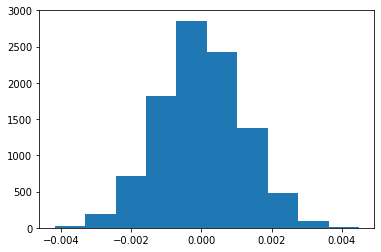

In [126]:
plt.hist(p_diffs);

Distribution under null hypothesis

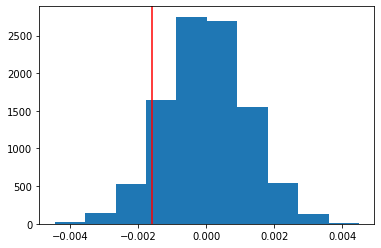

In [133]:
null_values = np.random.normal(0, p_diffs.std(), p_diffs.size);
plt.hist(null_values);
plt.axvline(obs_diff, color = 'red');

Calculating the probabilty of average p_diff > obs_diff

In [134]:
p_values = (p_diffs > obs_diff).mean()
p_values

0.9066

### Statistics
using statistics to compute Z-score to support a decision

In [137]:
import statsmodels.api as sm

convert_old = len(df_ecommerce[(df_ecommerce['landing_page'] == 'old_page') & (df_ecommerce['converted'] == 1)])
convert_new = len(df_ecommerce[(df_ecommerce['landing_page'] == 'new_page') & (df_ecommerce['converted'] == 1)])
n_old = len(df_ecommerce[df_ecommerce['landing_page'] == 'old_page'])
n_new = len(df_ecommerce[df_ecommerce['landing_page'] == 'new_page'])

In [139]:

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
print ("Z-Score:",z_score ,"P-Score:", p_value)

Z-Score: 1.3109241984234394 P-Score: 0.9050583127590245


Calculating critical value to compare with z score

In [140]:
from scipy.stats import norm

print("Z- Score:",norm.cdf(z_score))
print("Critical value:",norm.ppf(1-(0.05)/2))

Z- Score: 0.9050583127590245
Critical value: 1.959963984540054


### Conclusion
1.We find that the z-score of 1.3109241984234394  is less than the critical value of 1.95996398454. So, we accept the null hypothesis
2.The attraction of the old page is better than new page
3.Hence the null hypothesis is successful thereby rejecting the alternate hypothesis